# Model Connectivity Comparison Overview
The purpose of this notebook is to compare the current version of the RBC-GEM to earlier versions.
## Setup
### Import packages

In [1]:
from collections import defaultdict
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from cobra.manipulation import rename_genes
from rbc_gem_utils import (CURATION_PATH, GEM_NAME, GEM_URL, INTERIM_PATH,
                           MODEL_PATH, PROCESSED_PATH, ROOT_PATH, build_string,
                           read_cobra_model, read_rbc_model, show_versions)
from rbc_gem_utils.util import ensure_iterable
from rbc_gem_utils.visualization import cmap_map

# Display versions of last time notebook ran and worked
show_versions()
plt.rcParams["font.family"] = "Arial"


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM models
### Current model

In [2]:
current_model = read_rbc_model(filetype="xml")
current_model.metabolites.sort()
current_model.genes.sort()
current_model.reactions.sort()
current_model

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21


Name,RBC_GEM
Memory address,14dd4aa10
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


### Earlier models

In [3]:
# Probably a better way to do this instead of erroring out.
download = True
version = "0.2.0"
ftype = "xml"

filepath = f"{ROOT_PATH}{INTERIM_PATH}/{GEM_NAME}_{version}.{ftype}"

if download:
    response = requests.get(f"{GEM_URL}/{version}/{MODEL_PATH}/{GEM_NAME}.{ftype}")
    response.raise_for_status()

    # Write file
    # Is there a better way of checking whether binary file?
    if not response.encoding:
        with open(filepath, "wb") as file:
            file.write(response.content)
    else:
        with open(filepath, "w") as file:
            file.write(response.text)

prev_model_020 = read_cobra_model(filepath)
prev_model_020.metabolites.sort()
prev_model_020.genes.sort()
prev_model_020.reactions.sort()
prev_model_020.groups.sort()
# For comparison
group = prev_model_020.groups.get_by_id("Transport reactions")
group.id = "Transport, extracellular"


# For comparison rename genes and remove splice isoforms
rename_genes(
    prev_model_020,
    {g.id: g.annotation.get("hgnc.symbol") for g in prev_model_020.genes},
)
prev_model_020.repair()
print(f"Genes: {len(set([x.id for x in prev_model_020.genes]))}")
print(f"Metabolites (all): {len(set([x.id for x in prev_model_020.metabolites]))}")
print(
    "Metabolites (unique): {}".format(
        len({x.id.replace(f"_{x.compartment}", "") for x in prev_model_020.metabolites})
    )
)
print(
    f"Reactions: {len(set([x.id for x in prev_model_020.reactions.query(lambda x: not x.boundary)]))}"
)
prev_model_020

Genes: 283
Metabolites (all): 342
Metabolites (unique): 267
Reactions: 370


Name,iAB_RBC_283
Memory address,1512cb950
Number of metabolites,342
Number of reactions,469
Number of genes,283
Number of groups,33
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [4]:
len(prev_model_020.reactions.query(lambda x: x.subsystem != "Pseudoreactions"))

370

In [5]:
model_list = [prev_model_020, current_model]
model_data = defaultdict(dict)

save_figures = True
transparent = False
imagetype = "svg"

results_path = Path(
    f"{ROOT_PATH}{PROCESSED_PATH}/{current_model.id}/ConnectivityComparison"
)
results_path.mkdir(exist_ok=True, parents=True)

### Compare connectivities

In [6]:
def compute_connectivities(
    model,
    attribute_type="metabolites",
    compartments=None,
    exclude=None,
    sum_compartments=False,
    aggregate_ranking=False,
    include_boundary=False,
):
    """Compute the metabolite connectivities of the model.

    Parameters
    ----------
    model : Model
        The model object
    attribute_type : {"metabolites", "genes"}
        The type of object.
    compartments : list, None
        Compartments that should be accounted for. If ``None``, all metabolite compartments are utilized.
    exclude : iterable
        Contains identifiers for metabolites that should be excluded from calculations.
        Useful for excluding currency metabolites (e.g., hydrogen, water) from calculations.
    sum_compartments : bool
        Whether to treat the metabolite as one entity and sum metabolite connectivities across compartments.
        If True, the connectivity is determined without regard to the species compartment.
        If False, the connectivity is determined seperately for species in different compartments.
    aggregate_ranking : bool
        If True, metabolites that have the same connectivity value are grouped together.
        If False, metabolites are kept seperately.
    include_boundary : bool
        If True, pseudoreactions are included in the connectivity count.
        If False, metabolites are kept seperately.
    """
    if not include_boundary:
        # Copy model and remove boundaries
        model = model.copy()
        model.remove_groups([model.groups.get_by_id("Pseudoreactions")])
        model.remove_reactions(model.boundary)
    species = getattr(model, attribute_type)
    # Get compartments
    if compartments:
        compartments = ensure_iterable(compartments)
    else:
        compartments = sorted(model.compartments)

    # Exclude metabolites
    if exclude is None:
        exclude = set()
    else:
        exclude = {str(x) for x in ensure_iterable(exclude)}

    if attribute_type == "metabolites":
        species = species.query(
            lambda x: (
                (
                    not x.id.replace(f"_{x.compartment}", "") in exclude
                    and not x.id in exclude
                )
                if sum_compartments
                else (not x.id in exclude)
            )
        )
        species = species.query(lambda x: x.compartment in set(compartments))
    else:
        species = species.query(lambda x: not x.id in exclude)

    # Compute absolute connectivities
    absolute_connectivities = defaultdict(int)
    absolute_connectivities = pd.Series(
        {specie.id: len(specie.reactions) for specie in species}, name="absolute"
    ).sort_values(ascending=False)
    absolute_connectivities.index.name = attribute_type

    if sum_compartments and attribute_type == "metabolites":
        # Aggregate metabolites across compartments and sum
        absolute_connectivities = absolute_connectivities.rename(
            {
                sid: sid.replace(f"_{species.get_by_id(sid).compartment}", "")
                for sid in absolute_connectivities.index
            },
            axis=0,
        )
        absolute_connectivities = absolute_connectivities.groupby(
            absolute_connectivities.index
        ).sum()

    # Compute relative connectivities
    relative_connectivities = absolute_connectivities / absolute_connectivities.sum()
    relative_connectivities.name = "relative"
    # Create DataFrame
    df_connectivity = pd.merge(
        absolute_connectivities,
        relative_connectivities,
        left_index=True,
        right_index=True,
    )
    df_connectivity = df_connectivity.reset_index(drop=False)
    df_connectivity = df_connectivity.sort_values(
        ["absolute", attribute_type], ascending=False
    )

    if aggregate_ranking:
        # Aggregate metabolites that share the same ranking
        df_connectivity = (
            df_connectivity.groupby(["absolute", "relative"], as_index=False)
            .agg(lambda x: set(x))
            .sort_index(ascending=False)
        )
    # Reset index, reorganize columns, and return
    df_connectivity = df_connectivity.reset_index(drop=True).loc[
        :, [attribute_type, "absolute", "relative"]
    ]
    return df_connectivity

#### Calculate connectivities without excluding any metabolites

In [7]:
num_display = 15
sum_compartments = True
aggregate_ranking = False
include_boundary = False
attribute_type = "metabolites"
exclude_list = []

for model in model_list:
    compartments = ["e"]
    df_connectivity = compute_connectivities(
        model,
        attribute_type=attribute_type,
        compartments=compartments,
        exclude=exclude_list,
        sum_compartments=sum_compartments,
        aggregate_ranking=aggregate_ranking,
    )
    df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
        lambda x: build_string(x, sep=", ")
    )
    df_connectivity = df_connectivity.set_index("metabolites")
    df_connectivity.columns = pd.MultiIndex.from_product(
        [[model.compartments["e"]], df_connectivity.columns]
    )
    df_connectivity_e = df_connectivity.copy()

    compartments = ["c"]
    df_connectivity = compute_connectivities(
        model,
        attribute_type=attribute_type,
        compartments=compartments,
        exclude=exclude_list,
        sum_compartments=sum_compartments,
        aggregate_ranking=aggregate_ranking,
    )
    df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
        lambda x: build_string(x, sep=", ")
    )
    # table_data[attribute_type] = df_connectivity
    df_connectivity = df_connectivity.set_index("metabolites")
    df_connectivity.columns = pd.MultiIndex.from_product(
        [[model.compartments["c"]], df_connectivity.columns]
    )
    df_connectivity_c = df_connectivity.copy()

    df_metabolite_connectivity_table = pd.merge(
        df_connectivity_c,
        df_connectivity_e,
        left_index=True,
        right_index=True,
        how="outer",
    )

    compartments = None
    df_connectivity = compute_connectivities(
        model,
        attribute_type=attribute_type,
        compartments=compartments,
        exclude=exclude_list,
        sum_compartments=sum_compartments,
        aggregate_ranking=aggregate_ranking,
    )
    df_connectivity[attribute_type] = df_connectivity[attribute_type].apply(
        lambda x: build_string(x, sep=", ")
    )
    # table_data[attribute_type] = df_connectivity
    df_connectivity = df_connectivity.set_index("metabolites")
    df_connectivity.columns = pd.MultiIndex.from_product(
        [["total"], df_connectivity.columns]
    )
    df_connectivity_all = df_connectivity.copy()

    df_metabolite_connectivity_table = (
        pd.merge(
            df_connectivity_all,
            df_metabolite_connectivity_table,
            left_index=True,
            right_index=True,
            how="outer",
        )
        .fillna(0)
        .sort_values(by=("total", "absolute"), ascending=False)
    )
    for col in df_metabolite_connectivity_table.columns:
        if col[1] == "absolute":
            df_metabolite_connectivity_table[col] = df_metabolite_connectivity_table[
                col
            ].astype(int)
        else:
            df_metabolite_connectivity_table[col] = df_metabolite_connectivity_table[
                col
            ].astype(float)

    model_data[model.id][
        f"{attribute_type}-con-all"
    ] = df_metabolite_connectivity_table.copy()
    print(model.id)
    print(df_metabolite_connectivity_table.head(num_display))
    print()

Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpnvgepppk.lp
Reading time = 0.01 seconds
: 342 rows, 938 columns, 3344 nonzeros
Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpku6cfuph.lp
Reading time = 0.00 seconds
: 342 rows, 938 columns, 3344 nonzeros
Read LP format model from file /var/folders/5t/hk8m3g6d1jn25x5rssjgsrmm0000gn/T/tmpclr2djgr.lp
Reading time = 0.00 seconds
: 342 rows, 938 columns, 3344 nonzeros
iAB_RBC_283
               total            cytosol           extracellular space  \
            absolute  relative absolute  relative            absolute   
metabolites                                                             
h                201  0.127781      190  0.128726                  11   
h2o              123  0.078195      122  0.082656                   1   
atp               81  0.051494       81  0.054878                   0   
pi                69  0.043865       68  0.046070               

##### Visualize comparison

In [8]:
df_connectivity = model_data[prev_model_020.id][f"{attribute_type}-con-all"][
    "total"
].reset_index(drop=False)
df_connectivity

,metabolites,absolute,relative
0,h,201,0.127781
1,h2o,123,0.078195
2,atp,81,0.051494
3,pi,69,0.043865
4,adp,68,0.043229
...,...,...,...
262,oaa,1,0.000636
263,phpyr,1,0.000636
264,for,1,0.000636
265,bandmt,1,0.000636


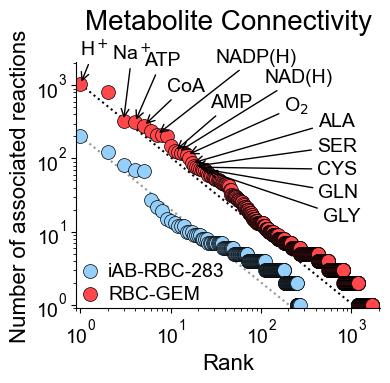

In [9]:
key = "absolute"
scale_points = False

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.despine(fig)

color_list = ["xkcd:light blue", "xkcd:light red"]
for idx, (model, color) in enumerate(zip(model_list, color_list)):
    if idx == len(model_list) - 1:
        refline_color = "black"
    else:
        refline_color = "xkcd:grey"
    df_connectivity = model_data[model.id][f"{attribute_type}-con-all"][
        "total"
    ].reset_index(drop=False)

    ax.scatter(
        df_connectivity[key].index + 1,  # Log plots do not do well with index of 0.
        df_connectivity[key].values,
        marker="o",
        edgecolors="black",
        lw=0.5,
        # linestyle="",
        color=color,
        s=df_connectivity["relative"].values * 10000 if scale_points else 100,
        zorder=2,
        label=model.id.replace("_", "-"),
    )
    # A reference line, linking the minimum and maximum connectivities
    ax.loglog(
        [df_connectivity[key].max(), df_connectivity[key].min()],
        [df_connectivity[key].min(), df_connectivity[key].max()],
        zorder=1,
        color=refline_color,
        linestyle=":",
    )
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(f"Metabolite Connectivity", fontdict={"size": 20}, y=1.1)
ax.set_xlabel("Rank", fontdict={"size": 16})
ax.set_ylabel("Number of associated reactions", fontdict={"size": 16})
ax.set_xlim(
    (0.9, df_connectivity[key].max() * 2)
)  # Add some padding for figure clarity
ax.set_ylim(
    (0.9, df_connectivity[key].max() * 2)
)  # Add some padding for figure clarity
ax.set_xticks([1e0, 1e1, 1e2, 1e3])
ax.set_yticks([1e0, 1e1, 1e2, 1e3])
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(
    frameon=False,
    bbox_to_anchor=(0.3, 0.75),
    loc="lower left",
    labelspacing=0.25,
    handlelength=0.25,
    fontsize=18,
)

mets_to_labels = {
    # Name, xscalar, yscalar
    "h": ("H$^+$", 1, 2.5),
    "na1": ("Na$^+$", 0.75, 7),
    "atp": ("ATP", 1.25, 6),
    "amp": ("AMP", 2.5, 4),
    "nadp": ("NADP(H)", 4.5, 10),
    "nad": ("NAD(H)", 9, 9),
    "coa": ("CoA", 1.8, 3),
    "o2": ("O$_2$", 12, 4),
    "ala__L": ("ALA", 25, 3.2),
    "ser__L": ("SER", 23, 1.6),
    "cys__L": ("CYS", 22, 0.8),
    "gln__L": ("GLN", 21.5, 0.4),
    "gly": ("GLY", 20, 0.2),
}
for i, row in df_connectivity[
    df_connectivity["metabolites"].isin(list(mets_to_labels))
].iterrows():
    x = i + 1
    met, y = row[["metabolites", "absolute"]].values
    name, xscalar, yscalar = mets_to_labels[met]
    ax.annotate(
        xy=(x, y),
        xytext=(x * xscalar, y * yscalar),
        text=name,
        xycoords="data",
        fontsize=14,
        arrowprops=dict(arrowstyle="->"),
    )


ax.legend(
    frameon=False,
    bbox_to_anchor=(-0.02, -0.05),
    loc="lower left",
    labelspacing=0.25,
    handlelength=0.25,
    fontsize=14,
)
fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{results_path}/{attribute_type}_connectivity_{model.id}_{version}.{imagetype}",
        transparent=transparent,
        dpi=None if imagetype != "png" else 600,
    )

### Comparison of subsystems


In [10]:
df_pathways = pd.read_csv(
    f"{ROOT_PATH}{CURATION_PATH}/subsystems.tsv", sep="\t", index_col=None, dtype=str
)
df_pathways = df_pathways.fillna("")
# Group "Metabolism of other amino acids" with amino acids rather than treat as "other"
df_pathways["category"] = df_pathways["category"].replace(
    "Metabolism of other amino acids", "Amino acid metabolism"
)
df_pathways

,name,category,kegg.pathway.name,kegg.pathway,notes
0,"Alanine, aspartate and glutamate metabolism",Amino acid metabolism,"Alanine, aspartate and glutamate metabolism",hsa00250,
1,Arginine and proline metabolism,Amino acid metabolism,Arginine and proline metabolism,hsa00330,
2,Cysteine and methionine metabolism,Amino acid metabolism,Cysteine and methionine metabolism,hsa00270,
3,"Glycine, serine and threonine metabolism",Amino acid metabolism,"Glycine, serine and threonine metabolism",hsa00260,
4,Histidine metabolism,Amino acid metabolism,Histidine metabolism,hsa00340,
...,...,...,...,...,...
73,Aminoacyl-tRNA biosynthesis,Translation,Aminoacyl-tRNA biosynthesis,has00970,
74,"Transport, extracellular",Transport reactions,,,Representative subsystem for all transport rea...
75,5-fluorouracil metabolism,Xenobiotics biodegradation and metabolism,Drug metabolism - other enzymes,hsa00983,"Subnetwork of KEGG pathway ""Drug metabolism - ..."
76,Azathioprine and 6-mercaptopurine metabolism,Xenobiotics biodegradation and metabolism,Drug metabolism - other enzymes,hsa00983,"Subnetwork of KEGG pathway ""Drug metabolism - ..."


In [11]:
# Categories that should be excluded from the figure
categories_to_exclude = {"Pseudoreactions", "Model total"}
# Main categories in figure and abbreviations, all unmapped categories are mapped to "Other"
categories_to_keep = {
    "Amino acid metabolism": mpl.cm.spring,
    "Carbohydrate metabolism": mpl.cm.Greens,
    "Lipid metabolism": mpl.cm.Blues,
    "Metabolism of cofactors and vitamins": mpl.cm.summer,
    "Nucleotide metabolism": mpl.cm.winter,
    "Reactive species": mpl.cm.Reds,
    "Transport reactions": mpl.cm.Purples,
    "Other": mpl.cm.gray_r,
}
use_abbrevs = True
abbrevs = {
    "Amino acid metabolism": "A",
    "Carbohydrate metabolism": "C",
    "Lipid metabolism": "L",
    "Metabolism of cofactors and vitamins": "V",
    "Nucleotide metabolism": "N",
    "Reactive species": "R",
    "Transport reactions": "T",
    "Other": "O",
}
barsize = 0.8
fontsize = 12
cmax = 0.8
cmin = 0.3


colormaps_normal = dict(
    zip(
        categories_to_keep,
        [
            cmap_map(lambda x: x * 1, categories_to_keep[k])(cmax)
            for k in categories_to_keep
        ],
    )
)
colormaps_light = dict(
    zip(
        categories_to_keep,
        [
            cmap_map(lambda x: x / 2 + 0.5, categories_to_keep[k])(cmax)
            for k in categories_to_keep
        ],
    )
)

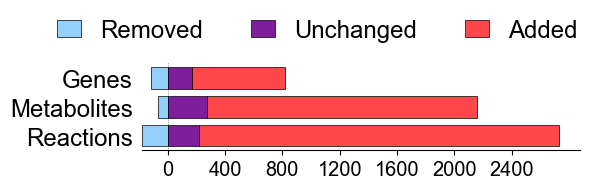

In [12]:
categories = ["Removed", "Unchanged", "Added"]
colors_dict = dict(
    zip(categories, ["xkcd:light blue", "xkcd:purple", "xkcd:light red"])
)
attribute_types = ["reactions", "metabolites", "genes"]
edgecolor = "black"
linewidth = 0.5
data = defaultdict(dict)
for attribute_type in attribute_types:
    try:
        df_removed = pd.read_csv(
            f"{ROOT_PATH}{CURATION_PATH}/{attribute_type}_removed.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
    except FileNotFoundError:
        df_removed = pd.DataFrame([], columns=[attribute_type], dtype=str)
    if attribute_type == "reactions":
        obj_lists = [
            getattr(model, attribute_type).query(lambda x: not x.boundary)
            for model in model_list
        ]
    else:
        obj_lists = [getattr(model, attribute_type) for model in model_list]

    shared = obj_lists[0].query(lambda x: x.id not in df_removed[attribute_type].values)
    removed = df_removed[attribute_type].values
    new = obj_lists[1].query(lambda x: x.id not in set(shared.list_attr("id")))
    data[attribute_type].update(
        dict(zip(categories, list(map(len, [removed, shared, new]))))
    )


df_data = pd.DataFrame.from_dict(data, orient="index")
df_data.index = df_data.index.str.capitalize()

fig, ax_general = plt.subplots(figsize=(6, 2))
total = df_data.cumsum(axis=1)
offsets = df_data[categories[0]].values
labels = [s.capitalize() for s in attribute_types]
tick_pos = [0.05, 0.11, 0.17]
for name, column in df_data.items():
    ax_general.barh(
        tick_pos,
        column.values,
        height=0.045,
        left=total[name] - column.values - offsets,
        color=colors_dict[name],
        edgecolor=edgecolor,
        linewidth=linewidth,
    )
    ax_general.set_yticks(tick_pos, labels=attribute_types)
    ax_general.set_yticklabels([s.capitalize() for s in attribute_types])

# Remove spines
ax_general.spines["right"].set_visible(False)
ax_general.spines["top"].set_visible(False)
ax_general.spines["left"].set_visible(False)
ax_general.axvline(0, linestyle=":", color="black", alpha=0.8, linewidth=linewidth)
xticks = list(np.linspace(0, 2400, 7))
ax_general.set_xticks(xticks)
ax_general.xaxis.set_major_formatter(lambda x, pos: int(abs(x)))
ax_general.yaxis.set_tick_params(left=False, labelsize="xx-large")
ax_general.xaxis.set_tick_params(labelsize="x-large")
legend = ax_general.legend(
    handles=[
        mpl.patches.Patch(
            label=label, facecolor=color, edgecolor=edgecolor, linewidth=linewidth
        )
        for label, color in colors_dict.items()
    ],
    frameon=False,
    edgecolor="black",
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(0.4, 1, 0, 0),
    fontsize="xx-large",
    handlelength=1,
)

fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{results_path}/{attribute_type}_GeneralComparision.{imagetype}",
        transparent=transparent,
        dpi=None if imagetype != "png" else 600,
    )

In [13]:
print(
    f"Number of unique genes in {prev_model_020.id}:\t\t{len([x.id for x in prev_model_020.genes])}\n"
    f"Number of unique metabolites in {prev_model_020.id}:\t{len(set([x.id.replace(f'_{x.compartment}', '') for x in prev_model_020.metabolites]))}\n"
    f"Number of biochemical reactions in {prev_model_020.id}:\t{len(prev_model_020.reactions.query(lambda x: x.subsystem != 'Pseudoreactions'))}\n"
)

print(
    f"Number of unique genes in {current_model.id}:\t\t{len([x.id for x in current_model.genes])}\n"
    f"Number of unique metabolites in {current_model.id}:\t{len(set([x.id.replace(f'_{x.compartment}', '') for x in current_model.metabolites]))}\n"
    f"Number of biochemical reactions in {current_model.id}:\t{len(current_model.reactions.query(lambda x: x.subsystem != 'Pseudoreactions'))}\n"
)

Number of unique genes in iAB_RBC_283:		283
Number of unique metabolites in iAB_RBC_283:	267
Number of biochemical reactions in iAB_RBC_283:	370

Number of unique genes in RBC_GEM:		820
Number of unique metabolites in RBC_GEM:	1685
Number of biochemical reactions in RBC_GEM:	2723



In [14]:
for idx, model in enumerate(model_list):
    data = defaultdict(dict)
    all_reactions = set()
    df_cat_subsystems = df_pathways.groupby("category")["name"].agg(lambda x: list(x))
    for category, subsystem_list in df_cat_subsystems.items():
        if category not in categories_to_keep and category not in categories_to_exclude:
            category = "Other"

        if category not in data:
            data[category] = {"Reactions": set(), "Metabolites": set(), "Genes": set()}
        # print([x for x in subsystem_list if not x in model.groups])
        subsystem_list = [x for x in subsystem_list if x in model.groups]
        reactions = [
            reaction
            for group in model.groups.get_by_any(subsystem_list)
            for reaction in group.members
        ]
        for reaction in reactions:
            all_reactions.update([reaction])
            data[category]["Reactions"].update([reaction])
            data[category]["Metabolites"].update(reaction.metabolites)
            data[category]["Genes"].update(reaction.genes)

    data["Model total"] = {
        "Reactions": model.reactions,
        "Metabolites": model.metabolites,
        "Genes": model.genes,
    }
    df_data = pd.DataFrame(
        {
            key: {k: len(x) for k, x in value_dict.items()}
            for key, value_dict in data.items()
        }
    ).T.sort_index()
    df_data = df_data.loc[df_data.index.difference(categories_to_exclude)]

    model_data[model.id][f"{attribute_type}-cat"] = df_data
    print(model.id, "\n", df_data, "\n")
df_comparison = pd.merge(
    model_data[model_list[0].id][f"{attribute_type}-cat"],
    model_data[model_list[1].id][f"{attribute_type}-cat"],
    left_index=True,
    right_index=True,
    suffixes=(f"_{model_list[0].id}", f"_{model_list[1].id}"),
)
df_comparison

iAB_RBC_283 
                                       Reactions  Metabolites  Genes
Amino acid metabolism                        24           51     27
Carbohydrate metabolism                     104          112     73
Lipid metabolism                             94           94     53
Metabolism of cofactors and vitamins         37           54     28
Nucleotide metabolism                        30           40     57
Other                                         3           10      3
Reactive species                              1            3      1
Transport reactions                          77          152     43 

RBC_GEM 
                                       Reactions  Metabolites  Genes
Amino acid metabolism                       281          276    100
Carbohydrate metabolism                     210          207    148
Lipid metabolism                            711          740    106
Metabolism of cofactors and vitamins        140          176     69
Nucleotide metabolism 

,Reactions_iAB_RBC_283,Metabolites_iAB_RBC_283,Genes_iAB_RBC_283,Reactions_RBC_GEM,Metabolites_RBC_GEM,Genes_RBC_GEM
Amino acid metabolism,24,51,27,281,276,100
Carbohydrate metabolism,104,112,73,210,207,148
Lipid metabolism,94,94,53,711,740,106
Metabolism of cofactors and vitamins,37,54,28,140,176,69
Nucleotide metabolism,30,40,57,171,146,127
Other,3,10,3,232,362,238
Reactive species,1,3,1,103,127,37
Transport reactions,77,152,43,875,890,150


In [15]:
print(list(model_data[current_model.id].keys()))
if save_figures:
    with pd.ExcelWriter(f"{results_path}/ModelComparison.xlsx") as writer:
        for model_name, dict_of_dfs in model_data.items():
            for sheet_name, df in dict_of_dfs.items():
                model_name = model_name.replace("_", "-")
                df.to_excel(writer, sheet_name=f"{model_name}-{sheet_name}", index=True)

['metabolites-con-all', 'genes-cat']
